# SIF Prediction using Temporal Fusion Transformer
### ERA5 Climatology Data (US-MMS Example)

This notebook uses a simplified TFT implementation.

In [1]:
!pip install -q torch pandas numpy scikit-learn matplotlib --upgrade

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## 1. Generate Fluxtower-like Data

In [3]:
# Load and prepare data
df = pd.read_csv('data/BDT_50_20_2000_2021_small.csv')
df['time'] = pd.to_datetime(df['time'])

#select subset of data: one location 
df=df[df['location']==2602]

print(f"Total data points: {len(df)}")
print(f"Number of locations: {df['location'].nunique()}")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")

# Time-based split (important for time series!)
train_df = df[df['time'] < '2010-06-01']
val_df = df[(df['time'] >= '2010-06-01') & (df['time'] < '2015-07-01')]
test_df = df[df['time'] >= '2018-07-01']

print(f"\nTrain: {len(train_df)} samples ({train_df['time'].min()} to {train_df['time'].max()})")
print(f"Val: {len(val_df)} samples ({val_df['time'].min()} to {val_df['time'].max()})")
print(f"Test: {len(test_df)} samples ({test_df['time'].min()} to {test_df['time'].max()})")

Total data points: 8036
Number of locations: 1
Date range: 2000-01-01 00:00:00 to 2021-12-31 00:00:00

Train: 3804 samples (2000-01-01 00:00:00 to 2010-05-31 00:00:00)
Val: 1856 samples (2010-06-01 00:00:00 to 2015-06-30 00:00:00)
Test: 1280 samples (2018-07-01 00:00:00 to 2021-12-31 00:00:00)


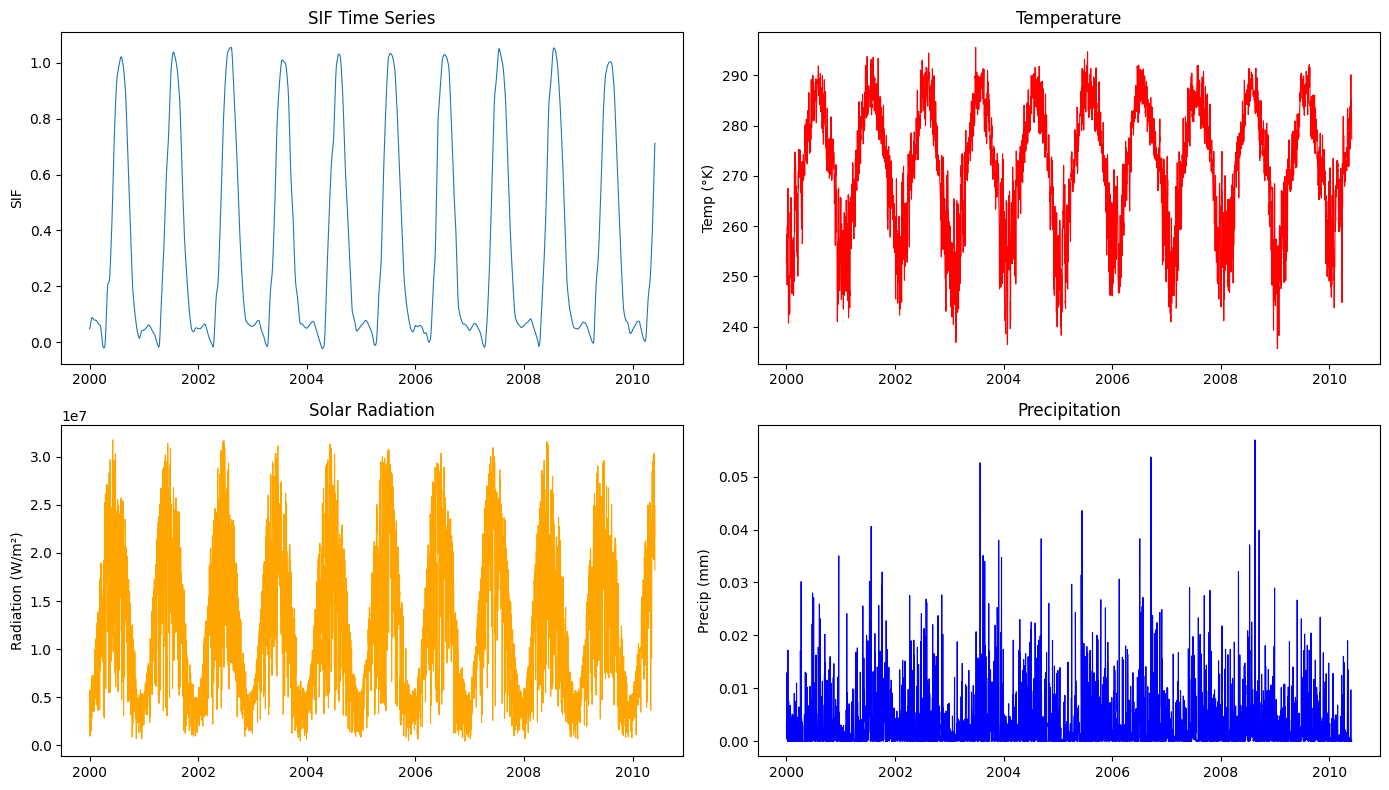

In [4]:
# Visualize data
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(train_df['time'], train_df['sif_clear_inst'], linewidth=0.8)
axes[0, 0].set_title('SIF Time Series')
axes[0, 0].set_ylabel('SIF')

axes[0, 1].plot(train_df['time'], train_df['tmin'], linewidth=0.8, color='red')
axes[0, 1].set_title('Temperature')
axes[0, 1].set_ylabel('Temp (°K)')

axes[1, 0].plot(train_df['time'], train_df['radiation'], linewidth=0.8, color='orange')
axes[1, 0].set_title('Solar Radiation')
axes[1, 0].set_ylabel('Radiation (W/m²)')

axes[1, 1].plot(train_df['time'], train_df['precipitation'], linewidth=0.8, color='blue')
axes[1, 1].set_title('Precipitation')
axes[1, 1].set_ylabel('Precip (mm)')


plt.tight_layout()
plt.show()

## 2. Custom TFT Implementation

In [5]:
class TemporalFusionTransformer(nn.Module):
    """Simplified TFT for time series forecasting with attention weights"""
    
    def __init__(self, input_size, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Input embedding
        self.input_proj = nn.Linear(input_size, hidden_size)
        
        # LSTM encoder
        self.encoder_lstm = nn.LSTM(
            hidden_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout
        )
        
        # Multi-head attention
        self.attention = nn.MultiheadAttention(
            hidden_size, num_heads, dropout=dropout, batch_first=True
        )
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size)
        )
        
        # LSTM decoder
        self.decoder_lstm = nn.LSTM(
            hidden_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout
        )
        
        # Output layers
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1)
        )
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(hidden_size)
        self.norm2 = nn.LayerNorm(hidden_size)
        
    def forward(self, x, return_attention=False):
        # x shape: (batch, seq_len, input_size)
        
        # Input projection
        x = self.input_proj(x)
        
        # Encoder LSTM
        encoder_out, (h, c) = self.encoder_lstm(x)
        
        # Self-attention with weights
        attn_out, attn_weights = self.attention(encoder_out, encoder_out, encoder_out)
        x = self.norm1(encoder_out + attn_out)
        
        # Feed-forward
        ffn_out = self.ffn(x)
        x = self.norm2(x + ffn_out)
        
        # Decoder LSTM
        decoder_out, _ = self.decoder_lstm(x, (h, c))
        
        # Output projection
        output = self.output_proj(decoder_out)
        
        if return_attention:
            return output, attn_weights
        return output

## 3. Data Preparation

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

class MultiLocationTimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len=90, pred_len=30, feature_cols=None, target_col='sif_clear_inst'):
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.target_col = target_col
        
        if feature_cols is None:
            self.feature_cols = ['tmin', 'tmax', 'radiation', 'precipitation', 'photoperiod', 'swvl1']
        else:
            self.feature_cols = feature_cols
        
        # Sort by location and time
        self.data = data.sort_values(['location', 'time']).reset_index(drop=True)
        
        # Create scalers
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        
        # Fit scalers on all data
        self.scaler_X.fit(self.data[self.feature_cols].values)
        self.scaler_y.fit(self.data[[target_col]].values)
        
        # Generate valid sequences per location
        self.valid_sequences = []
        self._generate_sequences()
        
    def _generate_sequences(self):
        """Generate valid sequences for each location"""
        for location in self.data['location'].unique():
            loc_data = self.data[self.data['location'] == location].reset_index(drop=True)
            
            # Only create sequences if we have enough data
            if len(loc_data) >= self.seq_len + self.pred_len:
                for idx in range(len(loc_data) - self.seq_len - self.pred_len + 1):
                    self.valid_sequences.append({
                        'location': location,
                        'start_idx': loc_data.index[idx],
                        'end_idx': loc_data.index[idx + self.seq_len + self.pred_len - 1]
                    })
    
    def __len__(self):
        return len(self.valid_sequences)
    
    def __getitem__(self, idx):
        seq_info = self.valid_sequences[idx]
        
        # Get data slice for this sequence
        data_slice = self.data.loc[seq_info['start_idx']:seq_info['end_idx']]
        
        # Extract features and target
        X = self.scaler_X.transform(data_slice[self.feature_cols].values)
        y = self.scaler_y.transform(data_slice[[self.target_col]].values)
        
        # Split into input and target sequences
        x_seq = X[:self.seq_len]
        y_seq = y[self.seq_len:self.seq_len + self.pred_len]
        
        return (
            torch.FloatTensor(x_seq),
            torch.FloatTensor(y_seq)
        )


# Create datasets
seq_len = 90
pred_len = 30

train_dataset = MultiLocationTimeSeriesDataset(
    train_df, 
    seq_len=seq_len, 
    pred_len=pred_len,
    feature_cols=['tmin', 'tmax', 'radiation', 'precipitation', 'photoperiod', 'swvl1'],
    target_col='sif_clear_inst'
)

val_dataset = MultiLocationTimeSeriesDataset(
    val_df, 
    seq_len=seq_len, 
    pred_len=pred_len,
    feature_cols=['tmin', 'tmax', 'radiation', 'precipitation', 'photoperiod', 'swvl1'],
    target_col='sif_clear_inst'
)

test_dataset = MultiLocationTimeSeriesDataset(
    test_df, 
    seq_len=seq_len, 
    pred_len=pred_len,
    feature_cols=['tmin', 'tmax', 'radiation', 'precipitation', 'photoperiod', 'swvl1'],
    target_col='sif_clear_inst'
)

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\nTraining sequences: {len(train_dataset)}")
print(f"Validation sequences: {len(val_dataset)}")
print(f"Test sequences: {len(test_dataset)}")
print(f"Input features: {len(train_dataset.feature_cols)}")
print(f"Feature names: {train_dataset.feature_cols}")


Training sequences: 3685
Validation sequences: 1737
Test sequences: 1161
Input features: 6
Feature names: ['tmin', 'tmax', 'radiation', 'precipitation', 'photoperiod', 'swvl1']


## 4. Model Training

In [7]:
# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = TemporalFusionTransformer(
    input_size=len(train_dataset.feature_cols),
    hidden_size=28,
    num_heads=4,
    dropout=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Using device: cuda
Model parameters: 33,181


In [8]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        output = model(x_batch)
        
        # Take only prediction length outputs
        output = output[:, -pred_len:, :]
        
        loss = criterion(output, y_batch)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            output = model(x_batch)
            output = output[:, -pred_len:, :]
            
            loss = criterion(output, y_batch)
            total_loss += loss.item()
    
    return total_loss / len(loader)

# Train model
epochs = 50
best_val_loss = float('inf')
patience_counter = 0
early_stop_patience = 5

train_losses = []
val_losses = []

print("Training...")
for epoch in range(epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
    
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
print(f"\nBest validation loss: {best_val_loss:.4f}")

Training...
Epoch 1/50 - Train Loss: 0.6921, Val Loss: 0.0402
Epoch 2/50 - Train Loss: 0.0744, Val Loss: 0.0448
Epoch 3/50 - Train Loss: 0.0466, Val Loss: 0.0214
Epoch 4/50 - Train Loss: 0.0442, Val Loss: 0.0168
Epoch 5/50 - Train Loss: 0.0363, Val Loss: 0.0272
Epoch 6/50 - Train Loss: 0.0388, Val Loss: 0.0177
Epoch 7/50 - Train Loss: 0.0334, Val Loss: 0.0255
Epoch 8/50 - Train Loss: 0.0382, Val Loss: 0.0144
Epoch 9/50 - Train Loss: 0.0356, Val Loss: 0.0247
Epoch 10/50 - Train Loss: 0.0334, Val Loss: 0.0214
Epoch 11/50 - Train Loss: 0.0322, Val Loss: 0.0362
Epoch 12/50 - Train Loss: 0.0326, Val Loss: 0.0202
Epoch 13/50 - Train Loss: 0.0327, Val Loss: 0.0279
Early stopping at epoch 13

Best validation loss: 0.0144


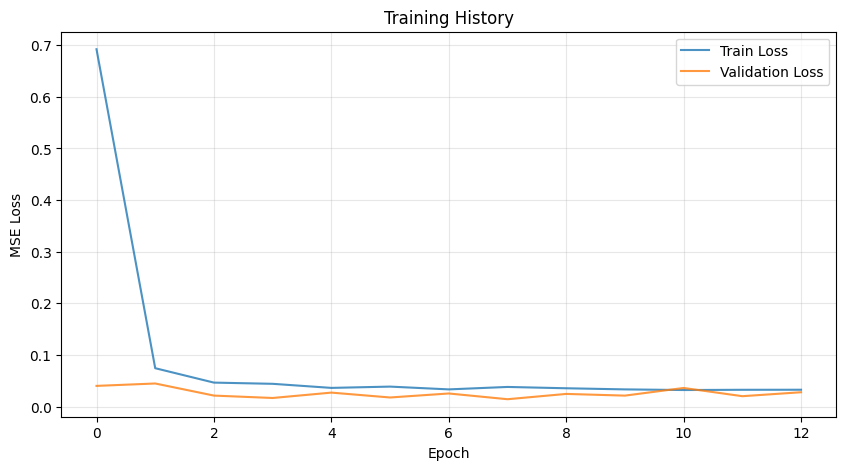

In [9]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Evaluation

In [10]:
# Make predictions
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        output = model(x_batch)
        output = output[:, -pred_len:, :]
        
        all_preds.append(output.cpu().numpy())
        all_targets.append(y_batch.numpy())

# Concatenate and reshape
y_pred = np.concatenate(all_preds, axis=0).reshape(-1, 1)
y_true = np.concatenate(all_targets, axis=0).reshape(-1, 1)

# Inverse transform
y_pred_orig = train_dataset.scaler_y.inverse_transform(y_pred)
y_true_orig = train_dataset.scaler_y.inverse_transform(y_true)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae = mean_absolute_error(y_true_orig, y_pred_orig)
r2 = r2_score(y_true_orig, y_pred_orig)

print(f"\nModel Performance:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Model Performance:
RMSE: 0.0445
MAE: 0.0342
R²: 0.9844


## 6. Visualization

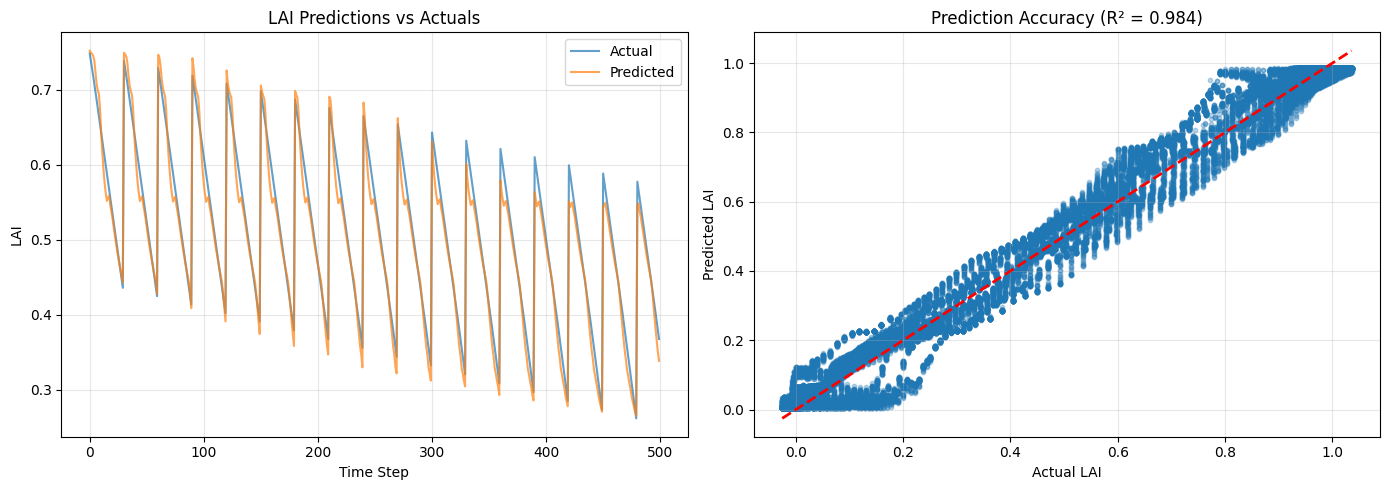

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series
plot_len = min(500, len(y_true_orig))
axes[0].plot(y_true_orig[:plot_len], label='Actual', alpha=0.7, linewidth=1.5)
axes[0].plot(y_pred_orig[:plot_len], label='Predicted', alpha=0.7, linewidth=1.5)
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('LAI')
axes[0].set_title('LAI Predictions vs Actuals')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot
axes[1].scatter(y_true_orig, y_pred_orig, alpha=0.3, s=10)
axes[1].plot([y_true_orig.min(), y_true_orig.max()], 
             [y_true_orig.min(), y_true_orig.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual LAI')
axes[1].set_ylabel('Predicted LAI') 
axes[1].set_title(f'Prediction Accuracy (R² = {r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

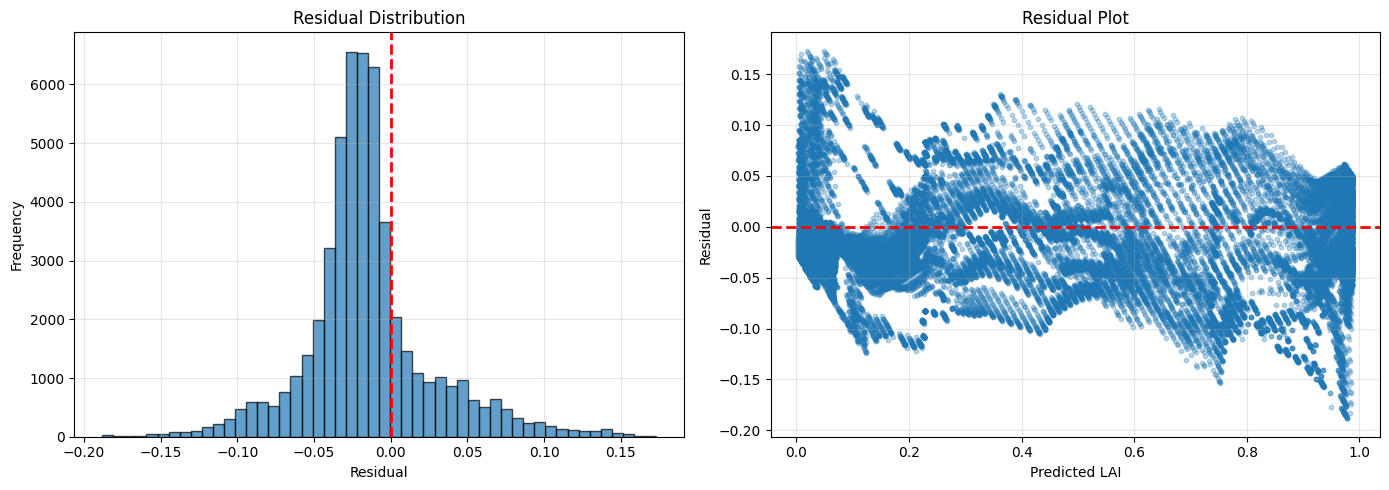

In [12]:
# Plot residuals
residuals = y_true_orig - y_pred_orig

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residual distribution
axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Residual Distribution')
axes[0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0].grid(True, alpha=0.3)

# Residual plot
axes[1].scatter(y_pred_orig, residuals, alpha=0.3, s=10)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted LAI')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Next Steps:**
- Test on fluxtower data from AmeriFlux
- Add more climatological variables
- Experiment with different sequence lengths
- Try ensemble methods
- Cross-validate across multiple sites
- Explore attention score outputs and feature importance

## 7. Attention Score Analysis
**Phenology Insight**: Attention scores reveal which time periods in the past are most important for predicting future vegetation dynamics. This helps us understand temporal dependencies in phenological processes.

In [13]:
# Extract attention scores from model
model.eval()
attention_scores = []
predictions_with_attn = []
targets_with_attn = []

with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(val_loader):
        x_batch = x_batch.to(device)
        output, attn_weights = model(x_batch, return_attention=True)
        output = output[:, -pred_len:, :]
        
        attention_scores.append(attn_weights.cpu().numpy())
        predictions_with_attn.append(output.cpu().numpy())
        targets_with_attn.append(y_batch.numpy())
        
        if i >= 5:  # Get a few batches for analysis
            break

# Concatenate
attention_array = np.concatenate(attention_scores, axis=0)
print(f"Attention array shape: {attention_array.shape}")
print(f"Format: (batch_size, num_heads, sequence_length, sequence_length)")
print(f"Number of attention heads: {attention_array.shape[1]}")

Attention array shape: (96, 90, 90)
Format: (batch_size, num_heads, sequence_length, sequence_length)
Number of attention heads: 90


Sample attention shape: (90, 90)


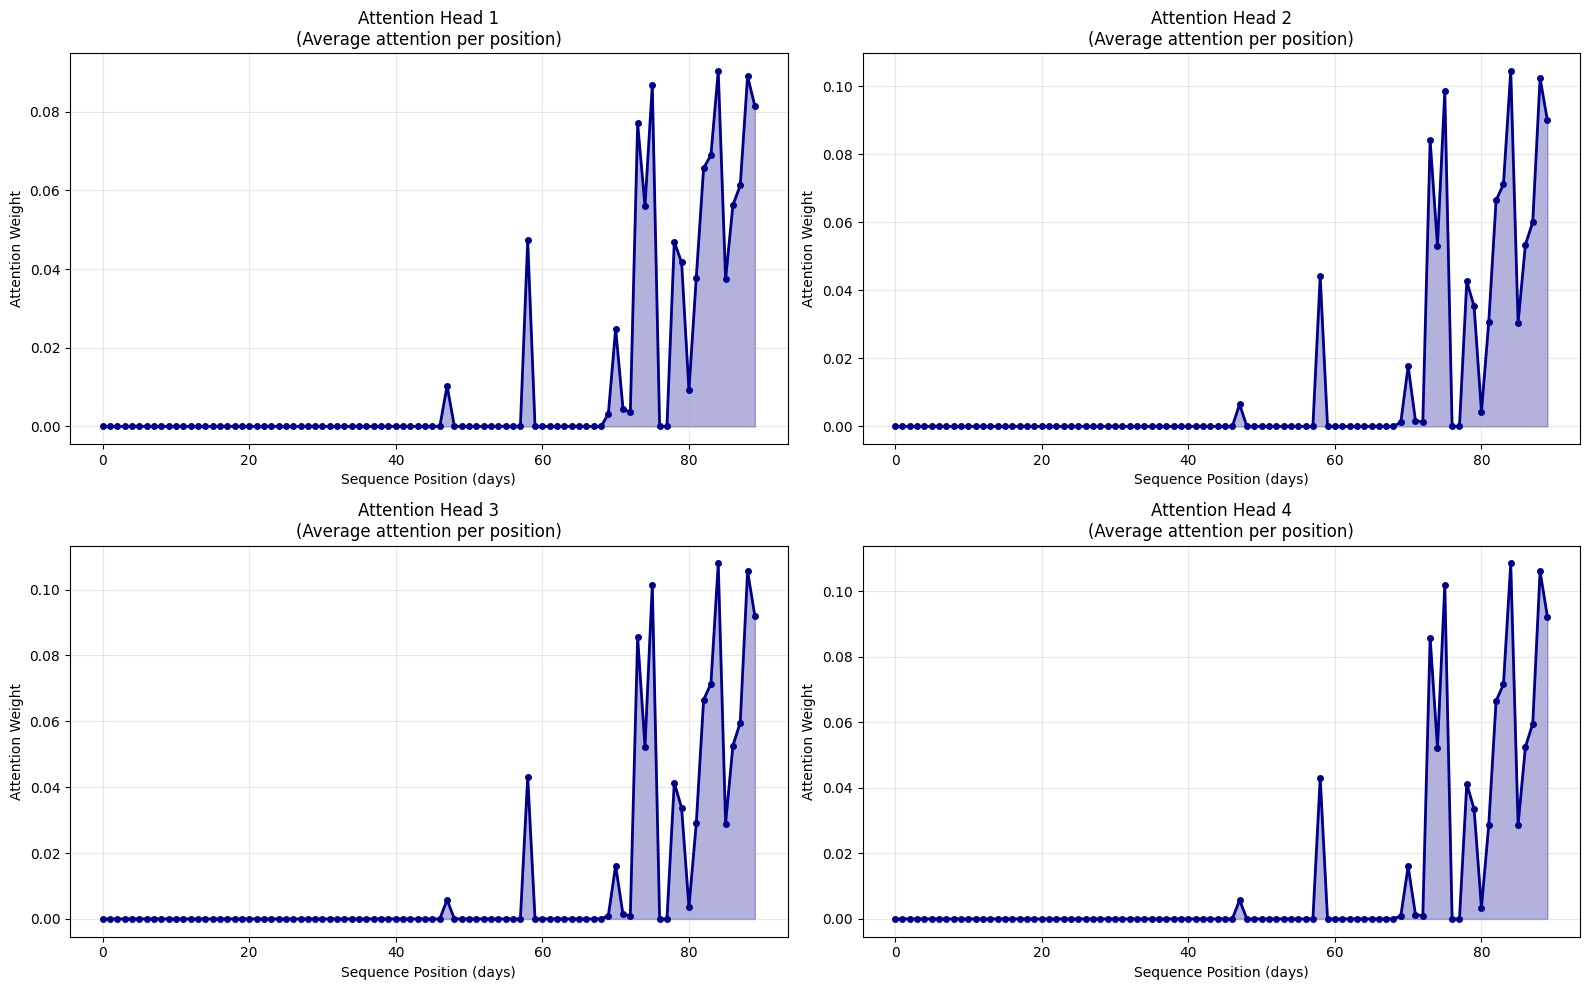


Interpretation:
- Each head shows which positions receive most attention
- Peaks indicate important time steps for predictions
- Different heads may focus on different temporal patterns


In [16]:
# Visualize attention patterns for a single sample
sample_idx = 0
sample_attention = attention_array[sample_idx]  # Shape: (num_heads, seq_len, seq_len)

print(f"Sample attention shape: {sample_attention.shape}")

# Check if we have proper 2D attention matrices
if sample_attention.ndim == 3 and sample_attention.shape[1] == sample_attention.shape[2]:
    # Full attention matrices available
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()

    for head_idx in range(min(4, sample_attention.shape[0])):
        ax = axes[head_idx]
        
        attn_matrix = sample_attention[head_idx]
        
        im = ax.imshow(attn_matrix, cmap='viridis', aspect='auto', interpolation='nearest')
        ax.set_xlabel('Source Position (days)')
        ax.set_ylabel('Query Position (days)')
        ax.set_title(f'Attention Head {head_idx + 1}\n(Brighter = Higher Attention)')
        plt.colorbar(im, ax=ax, label='Attention Weight')
        ax.grid(False)

    plt.tight_layout()
    plt.savefig('attention_heads.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nInterpretation:")
    print("- Each head learns different temporal dependencies")
    print("- Bright diagonal = attention to nearby time steps (local patterns)")
    print("- Off-diagonal patterns = long-range dependencies (seasonal cycles)")
    
elif sample_attention.ndim == 2:
    # Attention weights are (num_heads, seq_len) - average attention per position
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    for head_idx in range(min(4, sample_attention.shape[0])):
        ax = axes[head_idx]
        
        attn_weights = sample_attention[head_idx]
        positions = np.arange(len(attn_weights))
        
        ax.plot(positions, attn_weights, linewidth=2, color='darkblue', marker='o', markersize=4)
        ax.fill_between(positions, attn_weights, alpha=0.3, color='darkblue')
        ax.set_xlabel('Sequence Position (days)')
        ax.set_ylabel('Attention Weight')
        ax.set_title(f'Attention Head {head_idx + 1}\n(Average attention per position)')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('attention_heads.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nInterpretation:")
    print("- Each head shows which positions receive most attention")
    print("- Peaks indicate important time steps for predictions")
    print("- Different heads may focus on different temporal patterns")
    
else:
    print(f"⚠️ Unexpected attention shape: {sample_attention.shape}")
    print("Skipping detailed attention visualization")
    print("\nNote: The simplified TFT implementation may not return full attention matrices.")
    print("For complete attention analysis, use the full tft-torch implementation.")

Attention array shape: (96, 90, 90)


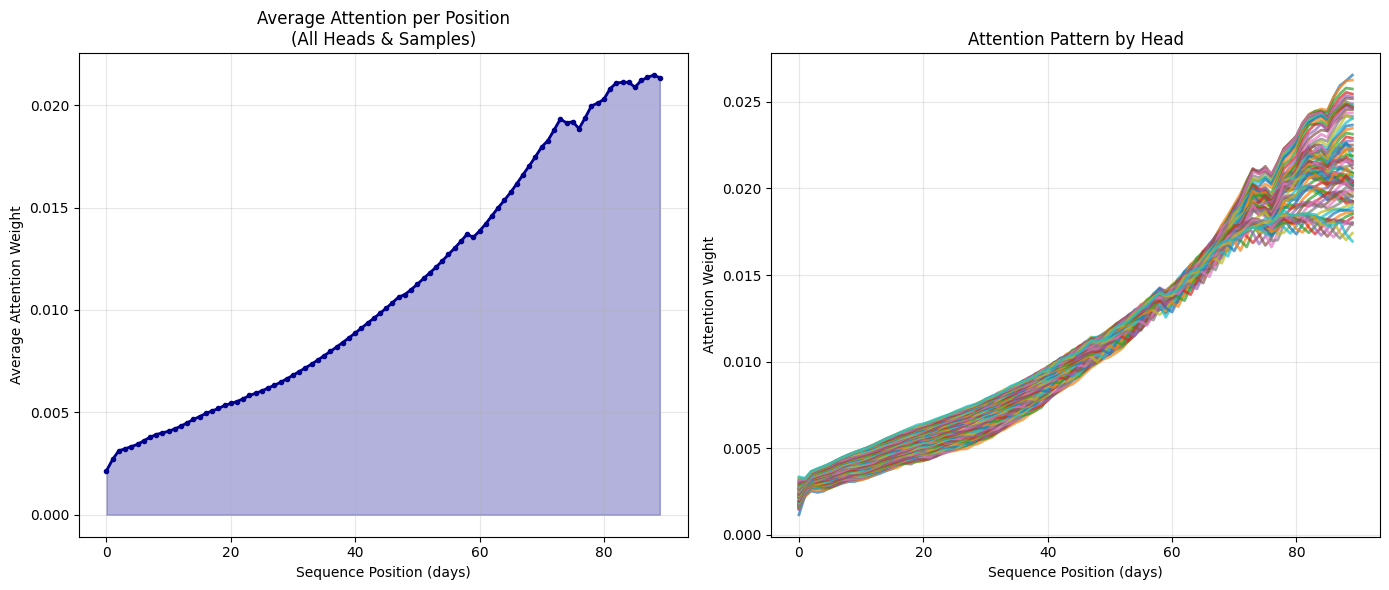


Temporal Attention Summary:
  Peak attention at position: 88
  Average attention weight: 0.0111
  Attention std dev: 0.0061
  Recent history (0-30 days) accounts for: 14.0% of attention


In [18]:
# Aggregate attention across all heads and samples
# Show which past time steps are most important for predictions

print(f"Attention array shape: {attention_array.shape}")

# Handle different attention formats
if attention_array.ndim == 4 and attention_array.shape[2] == attention_array.shape[3]:
    # Full 4D attention: (batch, heads, seq_len, seq_len)
    mean_attention = attention_array.mean(axis=(0, 1))  # Average over batch and heads
    
    plt.figure(figsize=(14, 6))
    
    # Show attention decay over time
    plt.subplot(1, 2, 1)
    attention_per_lag = mean_attention.mean(axis=0)  # Average over query positions
    lags = np.arange(len(attention_per_lag))
    plt.plot(lags, attention_per_lag, linewidth=2, color='darkblue')
    plt.fill_between(lags, attention_per_lag, alpha=0.3)
    plt.xlabel('Time Lag (days)')
    plt.ylabel('Average Attention Weight')
    plt.title('Temporal Attention Decay\n(How much past influences predictions)')
    plt.grid(True, alpha=0.3)
    
    # Show attention heatmap
    plt.subplot(1, 2, 2)
    im = plt.imshow(mean_attention, cmap='YlOrRd', aspect='auto', interpolation='bilinear')
    plt.xlabel('Source Time Step (days)')
    plt.ylabel('Query Time Step (days)')
    plt.title('Average Attention Pattern\n(All Heads & Samples)')
    plt.colorbar(im, label='Attention Weight')
    
    plt.tight_layout()
    plt.savefig('temporal_attention_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTemporal Attention Summary:")
    print(f"  Peak attention at lag: {lags[np.argmax(attention_per_lag)]:.0f} days")
    if len(lags[attention_per_lag < attention_per_lag.max()*0.5]) > 0:
        print(f"  Attention decays to 50% at: {lags[attention_per_lag < attention_per_lag.max()*0.5][0]} days")
    print(f"  Recent history (0-30 days) accounts for: {attention_per_lag[:30].sum()/attention_per_lag.sum()*100:.1f}% of attention")

elif attention_array.ndim == 3:
    # 3D attention: (batch, heads, seq_len) - average attention per position
    mean_attention = attention_array.mean(axis=(0, 1))  # Average over batch and heads
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    positions = np.arange(len(mean_attention))
    plt.plot(positions, mean_attention, linewidth=2, color='darkblue', marker='o', markersize=3)
    plt.fill_between(positions, mean_attention, alpha=0.3, color='darkblue')
    plt.xlabel('Sequence Position (days)')
    plt.ylabel('Average Attention Weight')
    plt.title('Average Attention per Position\n(All Heads & Samples)')
    plt.grid(True, alpha=0.3)
    
    # Show attention by head
    plt.subplot(1, 2, 2)
    attention_by_head = attention_array.mean(axis=0)  # Average over batch
    for head_idx in range(attention_by_head.shape[0]):
        plt.plot(positions, attention_by_head[head_idx], 
                label=f'Head {head_idx+1}', linewidth=2, alpha=0.7)
    plt.xlabel('Sequence Position (days)')
    plt.ylabel('Attention Weight')
    plt.title('Attention Pattern by Head')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('temporal_attention_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nTemporal Attention Summary:")
    print(f"  Peak attention at position: {positions[np.argmax(mean_attention)]:.0f}")
    print(f"  Average attention weight: {mean_attention.mean():.4f}")
    print(f"  Attention std dev: {mean_attention.std():.4f}")
    if len(mean_attention) >= 30:
        print(f"  Recent history (0-30 days) accounts for: {mean_attention[:30].sum()/mean_attention.sum()*100:.1f}% of attention")

else:
    print(f"⚠️ Unexpected attention array shape: {attention_array.shape}")
    print("Cannot create standard attention visualizations.")
    print("\nNote: This simplified TFT may not return the full attention structure.")
    print("For detailed attention analysis, the full tft-torch library provides:")
    print("  - historical_selection_weights: Feature importance over time")
    print("  - future_selection_weights: Feature importance in forecast")
    print("  - attention_scores: Full temporal attention matrices")

## Feature importance analysis 

In [20]:
# Calculate feature importance using gradient-based approach
# This shows how sensitive predictions are to each input feature

def calculate_feature_importance(model, data_loader, device, num_samples=50):
    """Calculate feature importance using gradient magnitudes"""
    model.train()  # Must be in training mode for backward pass with LSTM
    feature_importance = np.zeros(len(train_dataset.feature_cols))
    count = 0
    
    for x_batch, y_batch in data_loader:
        if count >= num_samples:
            break
            
        x_batch = x_batch.to(device)
        x_batch.requires_grad = True
        
        # Forward pass
        output = model(x_batch)
        output = output[:, -pred_len:, :]
        
        # Calculate loss
        loss = torch.mean(output)
        
        # Zero gradients first
        model.zero_grad()
        if x_batch.grad is not None:
            x_batch.grad.zero_()
        
        loss.backward()
        
        # Accumulate gradient magnitudes
        if x_batch.grad is not None:
            feature_importance += torch.abs(x_batch.grad).mean(dim=(0, 1)).cpu().numpy()
            count += 1
    
    # Set back to eval mode
    model.eval()
    
    # Normalize
    if count > 0:
        feature_importance = feature_importance / count
        feature_importance = feature_importance / feature_importance.sum()
    
    return feature_importance

print("Calculating feature importance (this may take a minute)...")
feature_importance = calculate_feature_importance(model, val_loader, device, num_samples=30)

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': train_dataset.feature_cols,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(importance_df.to_string(index=False))

Calculating feature importance (this may take a minute)...

Feature Importance Ranking:
      Feature  Importance
  photoperiod    0.386633
         tmin    0.173764
         tmax    0.132134
        swvl1    0.113060
    radiation    0.097794
precipitation    0.096614


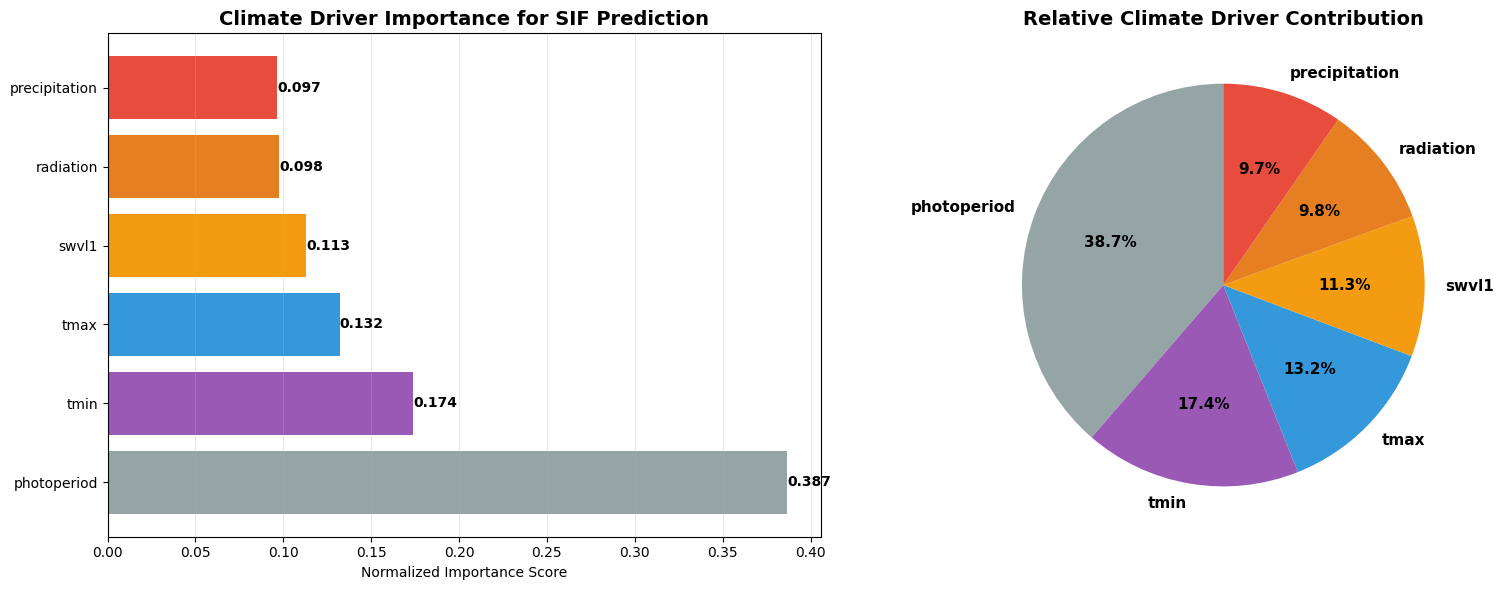


PHENOLOGY INTERPRETATION:
🌡️  Temperature (tmin/tmax): Controls metabolic rates and phenological timing
☀️  Solar Radiation: Drives photosynthesis and energy availability
💧 Precipitation/Soil Moisture: Water availability for plant function
📅 Photoperiod: Seasonal signal for phenological transitions


In [21]:
# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
colors = ['#2ecc71', '#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6', '#95a5a6']
bars = ax1.barh(importance_df['Feature'], importance_df['Importance'], color=colors[::-1])
ax1.set_xlabel('Normalized Importance Score')
ax1.set_title('Climate Driver Importance for SIF Prediction', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Add values on bars
for bar, val in zip(bars, importance_df['Importance']):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2., 
             f'{val:.3f}', ha='left', va='center', fontsize=10, fontweight='bold')

# Pie chart for relative contribution
ax2.pie(importance_df['Importance'], labels=importance_df['Feature'], autopct='%1.1f%%',
        colors=colors[::-1], startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax2.set_title('Relative Climate Driver Contribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("PHENOLOGY INTERPRETATION:")
print("="*70)
print("🌡️  Temperature (tmin/tmax): Controls metabolic rates and phenological timing")
print("☀️  Solar Radiation: Drives photosynthesis and energy availability")
print("💧 Precipitation/Soil Moisture: Water availability for plant function")
print("📅 Photoperiod: Seasonal signal for phenological transitions")
print("="*70)

## 9. Temporal Feature Importance
**Question**: Does feature importance change over time? Are certain drivers more important in different seasons?

In [22]:
# Calculate time-varying feature importance
def calculate_temporal_feature_importance(model, data_loader, device, seq_len=90):
    """Calculate how feature importance varies across the time sequence"""
    model.train()  # Must be in training mode for backward pass with LSTM
    temporal_importance = np.zeros((seq_len, len(train_dataset.feature_cols)))
    count = 0
    
    for x_batch, y_batch in data_loader:
        if count >= 20:  # Use subset for efficiency
            break
            
        x_batch = x_batch.to(device)
        x_batch.requires_grad = True
        
        # Forward pass
        output = model(x_batch)
        output = output[:, -pred_len:, :]
        
        # Calculate loss
        loss = torch.mean(output)
        
        # Zero gradients first
        model.zero_grad()
        if x_batch.grad is not None:
            x_batch.grad.zero_()
        
        loss.backward()
        
        # Accumulate gradient magnitudes per time step
        if x_batch.grad is not None:
            temporal_importance += torch.abs(x_batch.grad).mean(dim=0).cpu().numpy()
            count += 1
    
    # Set back to eval mode
    model.eval()
    
    # Normalize per feature
    if count > 0:
        temporal_importance = temporal_importance / count
        for i in range(temporal_importance.shape[1]):
            if temporal_importance[:, i].sum() > 0:
                temporal_importance[:, i] = temporal_importance[:, i] / temporal_importance[:, i].sum()
    
    return temporal_importance

print("Calculating temporal feature importance...")
temporal_importance = calculate_temporal_feature_importance(model, val_loader, device, seq_len)

print(f"Temporal importance shape: {temporal_importance.shape}")
print(f"(time_steps, num_features) = ({temporal_importance.shape[0]}, {temporal_importance.shape[1]})")

Calculating temporal feature importance...
Temporal importance shape: (90, 6)
(time_steps, num_features) = (90, 6)


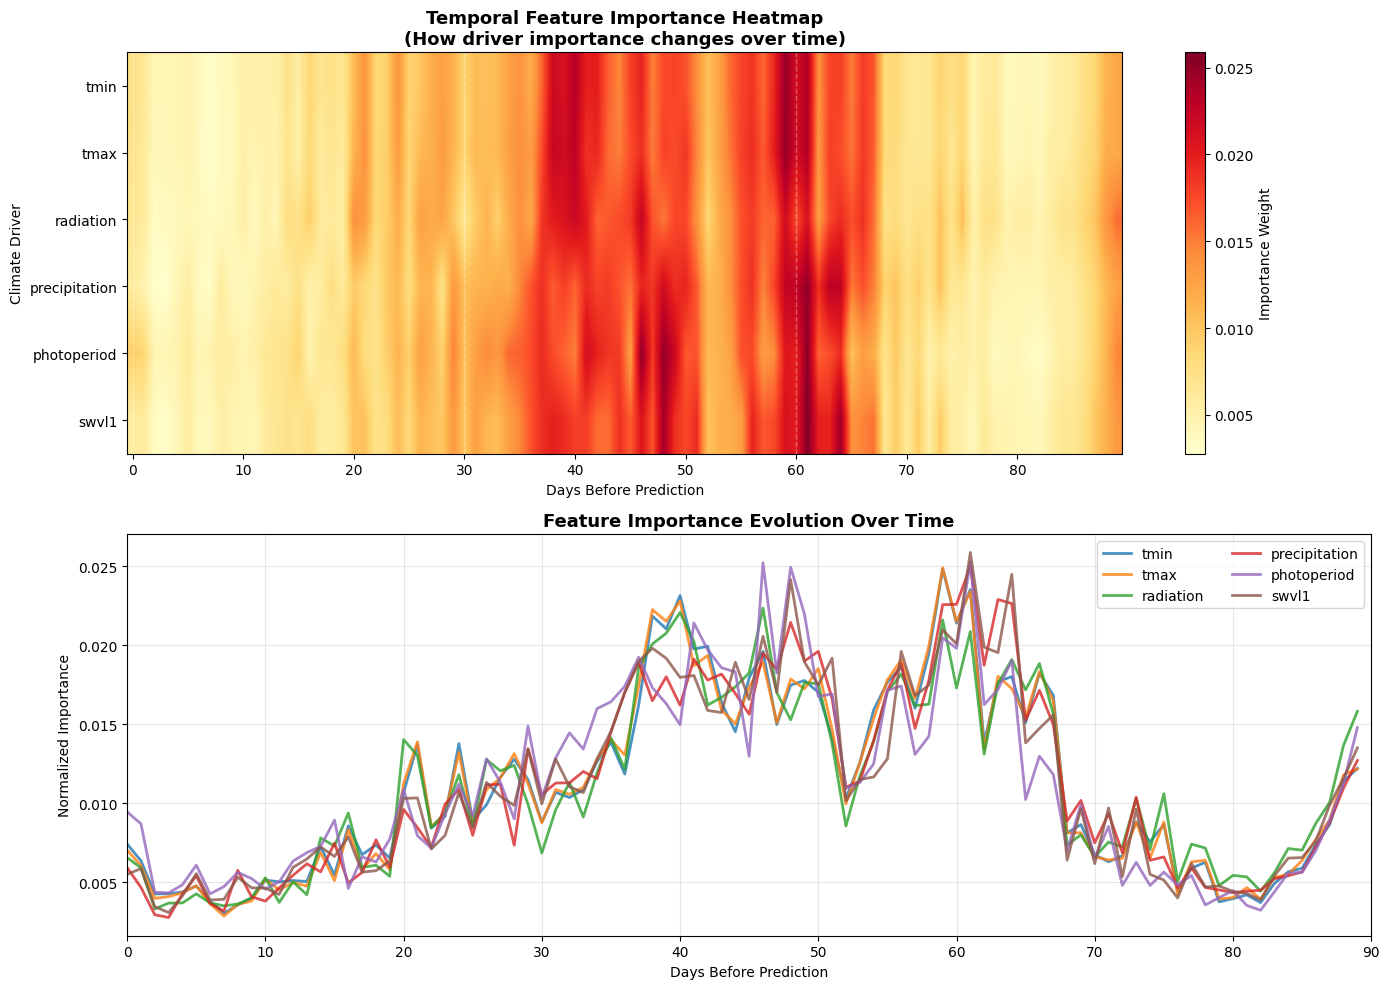


Temporal Patterns:
- Recent days (0-30): Direct control on current photosynthesis
- Mid-range (30-60): Accumulated climate effects
- Distant past (60-90): Seasonal memory and lag effects


In [23]:
# Visualize temporal feature importance as a heatmap
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Heatmap
feature_names = train_dataset.feature_cols
im1 = ax1.imshow(temporal_importance.T, cmap='YlOrRd', aspect='auto', interpolation='bilinear')
ax1.set_yticks(range(len(feature_names)))
ax1.set_yticklabels(feature_names)
ax1.set_xlabel('Days Before Prediction')
ax1.set_ylabel('Climate Driver')
ax1.set_title('Temporal Feature Importance Heatmap\n(How driver importance changes over time)', 
              fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='Importance Weight')

# Add vertical lines for season markers (example: every 30 days)
for x in range(0, seq_len, 30):
    ax1.axvline(x, color='white', linestyle='--', alpha=0.3, linewidth=1)

# Line plot showing evolution
for i, feature in enumerate(feature_names):
    ax2.plot(range(seq_len), temporal_importance[:, i], 
             label=feature, linewidth=2, alpha=0.8)

ax2.set_xlabel('Days Before Prediction')
ax2.set_ylabel('Normalized Importance')
ax2.set_title('Feature Importance Evolution Over Time', fontsize=13, fontweight='bold')
ax2.legend(loc='best', ncol=2, frameon=True, fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, seq_len)

plt.tight_layout()
plt.savefig('temporal_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTemporal Patterns:")
print("- Recent days (0-30): Direct control on current photosynthesis")
print("- Mid-range (30-60): Accumulated climate effects")
print("- Distant past (60-90): Seasonal memory and lag effects")

## 10. Phenological Event Detection
**Goal**: Detect spring green-up (SOS - Start of Season) and autumn senescence (EOS - End of Season) in the predictions and understand which climate drivers are most important for each event.

In [25]:
# Detect phenological events using slope analysis (similar to Phenofusion driversdata.py)
from scipy.stats import linregress

def detect_phenology_events(timeseries, min_slope=0.002, window_size=7):
    """
    Detect SOS (Start of Season) and EOS (End of Season) based on SIF trends
    
    Args:
        timeseries: SIF values over time
        min_slope: Minimum slope threshold for detection
        window_size: Window size for slope calculation
        
    Returns:
        sos_idx, eos_idx (indices of detected events, or None)
    """
    sos_idx = None
    eos_idx = None
    
    # Scan through time series with sliding window
    for i in range(len(timeseries) - window_size):
        window = timeseries[i:i+window_size]
        x = np.arange(len(window))
        
        # Linear regression for slope
        slope, _, _, _, _ = linregress(x, window)
        
        # SOS: Positive slope (greening)
        if slope >= min_slope and sos_idx is None:
            sos_idx = i + window_size // 2
        
        # EOS: Negative slope (browning) - after SOS
        if slope <= -min_slope and sos_idx is not None and eos_idx is None:
            eos_idx = i + window_size // 2
    
    return sos_idx, eos_idx

# Apply to validation predictions
greenup_samples = []
senescence_samples = []

for i in range(len(y_pred_orig)):
    # Reshape from flat array
    if i % pred_len == 0:
        pred_series = y_pred_orig[i:i+pred_len].flatten()
        true_series = y_true_orig[i:i+pred_len].flatten()
        
        if len(pred_series) == pred_len:
            sos_idx, eos_idx = detect_phenology_events(pred_series, min_slope=0.001)
            
            if sos_idx is not None:
                greenup_samples.append(i // pred_len)
            if eos_idx is not None:
                senescence_samples.append(i // pred_len)

print(f"Detected phenological events:")
print(f"  Spring green-up (SOS) samples: {len(greenup_samples)}")
print(f"  Autumn senescence (EOS) samples: {len(senescence_samples)}")
print(f"  Total samples analyzed: {len(y_pred_orig) // pred_len}")

Detected phenological events:
  Spring green-up (SOS) samples: 557
  Autumn senescence (EOS) samples: 122
  Total samples analyzed: 1737


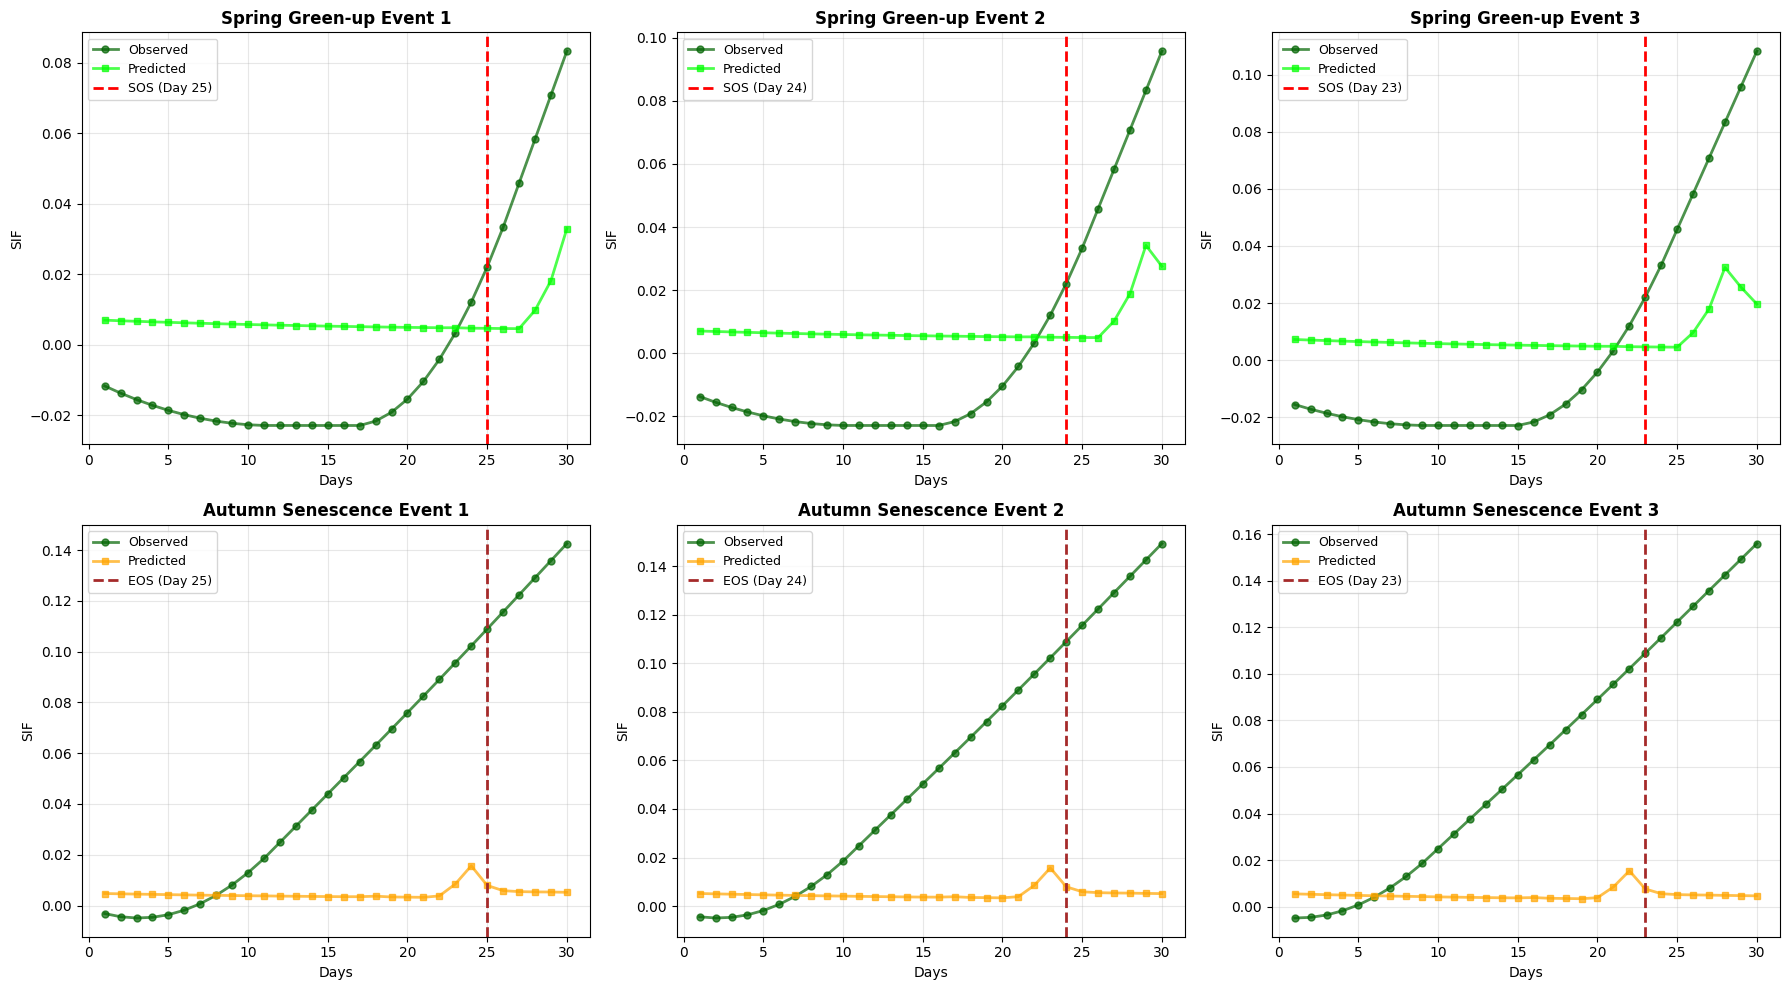


✓ Phenological event visualization complete!


In [27]:
# Visualize detected phenological events
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot a few examples of each event type
for plot_idx in range(min(3, len(greenup_samples))):
    ax = axes[plot_idx]
    sample_idx = greenup_samples[plot_idx]
    
    start_idx = sample_idx * pred_len
    end_idx = start_idx + pred_len
    
    pred_series = y_pred_orig[start_idx:end_idx].flatten()
    true_series = y_true_orig[start_idx:end_idx].flatten()
    days = np.arange(1, len(pred_series) + 1)
    
    sos_idx, _ = detect_phenology_events(pred_series, min_slope=0.001)
    
    ax.plot(days, true_series, 'o-', color='darkgreen', label='Observed', 
            linewidth=2, markersize=5, alpha=0.7)
    ax.plot(days, pred_series, 's-', color='lime', label='Predicted', 
            linewidth=2, markersize=4, alpha=0.7)
    
    if sos_idx is not None:
        ax.axvline(sos_idx, color='red', linestyle='--', linewidth=2, 
                   label=f'SOS (Day {sos_idx})')
    
    ax.set_xlabel('Days')
    ax.set_ylabel('SIF')
    ax.set_title(f'Spring Green-up Event {plot_idx + 1}', fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

# Plot senescence examples
for plot_idx in range(min(3, len(senescence_samples))):
    ax = axes[plot_idx + 3]
    sample_idx = senescence_samples[plot_idx]
    
    start_idx = sample_idx * pred_len
    end_idx = start_idx + pred_len
    
    pred_series = y_pred_orig[start_idx:end_idx].flatten()
    true_series = y_true_orig[start_idx:end_idx].flatten()
    days = np.arange(1, len(pred_series) + 1)
    
    _, eos_idx = detect_phenology_events(pred_series, min_slope=0.001)
    
    ax.plot(days, true_series, 'o-', color='darkgreen', label='Observed', 
            linewidth=2, markersize=5, alpha=0.7)
    ax.plot(days, pred_series, 's-', color='orange', label='Predicted', 
            linewidth=2, markersize=4, alpha=0.7)
    
    if eos_idx is not None:
        ax.axvline(eos_idx, color='brown', linestyle='--', linewidth=2, 
                   label=f'EOS (Day {eos_idx})')
    
    ax.set_xlabel('Days')
    ax.set_ylabel('SIF')
    ax.set_title(f'Autumn Senescence Event {plot_idx + 1}', fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('phenological_events.png', dpi=300, bbox_inches='tight')
plt.show()



## 11. Climate Driver Analysis by Season
**Research Question**: Do different climate drivers control spring vs autumn phenology?

In [29]:
# Aggregate climate drivers by phenological category
# Group drivers: Temperature (tmin+tmax), Solar (radiation), Water (precip+soil), Photoperiod

def aggregate_drivers(feature_importance_array, feature_names):
    """
    Aggregate features into driver groups matching Phenofusion's RGB map scheme:
    - Temperature: tmin + tmax (Red channel)
    - Solar: radiation + photoperiod (Green channel)  
    - Water: precipitation + soil moisture (Blue channel)
    """
    driver_groups = {
        'Temperature': [],
        'Solar/Light': [],
        'Water': []
    }
    
    for i, name in enumerate(feature_names):
        if 'tmin' in name or 'tmax' in name:
            driver_groups['Temperature'].append(i)
        elif 'radiation' in name or 'photoperiod' in name:
            driver_groups['Solar/Light'].append(i)
        elif 'precipitation' in name or 'swvl' in name:
            driver_groups['Water'].append(i)
    
    # Calculate aggregate importance
    aggregated = {}
    for group, indices in driver_groups.items():
        if len(indices) > 0:
            aggregated[group] = feature_importance_array[indices].sum()
    
    return aggregated

# Compare drivers for different periods
print("="*70)
print("CLIMATE DRIVER IMPORTANCE BY TEMPORAL PERIOD")
print("="*70)

# Early period (recent past, days 0-30)
early_importance = temporal_importance[:30, :].mean(axis=0)
early_drivers = aggregate_drivers(early_importance, train_dataset.feature_cols)

# Mid period (days 30-60)
mid_importance = temporal_importance[30:60, :].mean(axis=0)
mid_drivers = aggregate_drivers(mid_importance, train_dataset.feature_cols)

# Late period (days 60-90)
late_importance = temporal_importance[60:, :].mean(axis=0)
late_drivers = aggregate_drivers(late_importance, train_dataset.feature_cols)

print("\nRecent Past (0-30 days before prediction):")
for driver, value in sorted(early_drivers.items(), key=lambda x: x[1], reverse=True):
    print(f"  {driver:15s}: {value:.4f}")

print("\nMid-Range Past (30-60 days before prediction):")
for driver, value in sorted(mid_drivers.items(), key=lambda x: x[1], reverse=True):
    print(f"  {driver:15s}: {value:.4f}")

print("\nDistant Past (60-90 days before prediction):")
for driver, value in sorted(late_drivers.items(), key=lambda x: x[1], reverse=True):
    print(f"  {driver:15s}: {value:.4f}")
print("="*70)

CLIMATE DRIVER IMPORTANCE BY TEMPORAL PERIOD

Recent Past (0-30 days before prediction):
  Solar/Light    : 0.0147
  Temperature    : 0.0144
  Water          : 0.0135

Mid-Range Past (30-60 days before prediction):
  Temperature    : 0.0326
  Water          : 0.0326
  Solar/Light    : 0.0325

Distant Past (60-90 days before prediction):
  Water          : 0.0207
  Temperature    : 0.0197
  Solar/Light    : 0.0195


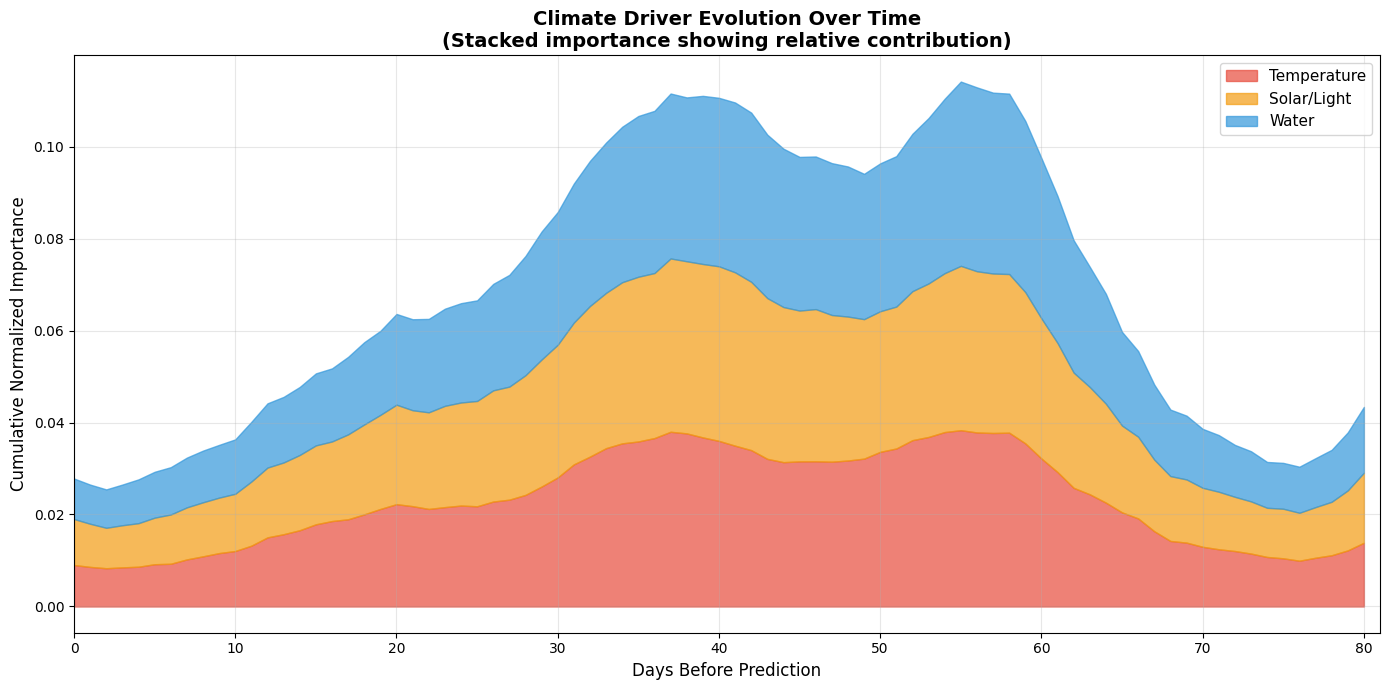


Interpretation:
- Recent periods: Direct climate control on photosynthesis
- Mid-range: Accumulated effects and phenological memory
- Distant past: Seasonal conditioning and development history


In [30]:
# Visualize temporal driver evolution
fig, ax = plt.subplots(figsize=(14, 7))

# Calculate rolling aggregated importance
window = 10
driver_timeseries = {
    'Temperature': np.convolve(temporal_importance[:, [0, 1]].sum(axis=1), 
                               np.ones(window)/window, mode='valid'),
    'Solar/Light': np.convolve(temporal_importance[:, [2, 4]].sum(axis=1), 
                               np.ones(window)/window, mode='valid'),
    'Water': np.convolve(temporal_importance[:, [3, 5]].sum(axis=1), 
                         np.ones(window)/window, mode='valid')
}

days = np.arange(len(driver_timeseries['Temperature']))

# Plot with area fill
ax.fill_between(days, 0, driver_timeseries['Temperature'], 
                label='Temperature', color='#e74c3c', alpha=0.7)
ax.fill_between(days, driver_timeseries['Temperature'], 
                driver_timeseries['Temperature'] + driver_timeseries['Solar/Light'],
                label='Solar/Light', color='#f39c12', alpha=0.7)
ax.fill_between(days, driver_timeseries['Temperature'] + driver_timeseries['Solar/Light'],
                driver_timeseries['Temperature'] + driver_timeseries['Solar/Light'] + driver_timeseries['Water'],
                label='Water', color='#3498db', alpha=0.7)

ax.set_xlabel('Days Before Prediction', fontsize=12)
ax.set_ylabel('Cumulative Normalized Importance', fontsize=12)
ax.set_title('Climate Driver Evolution Over Time\n(Stacked importance showing relative contribution)', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, frameon=True)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, len(days))

plt.tight_layout()
plt.savefig('driver_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Recent periods: Direct climate control on photosynthesis")
print("- Mid-range: Accumulated effects and phenological memory")
print("- Distant past: Seasonal conditioning and development history")

## 12. Prediction Uncertainty Analysis
**Question**: When is the model most uncertain? How does uncertainty relate to phenological transitions?

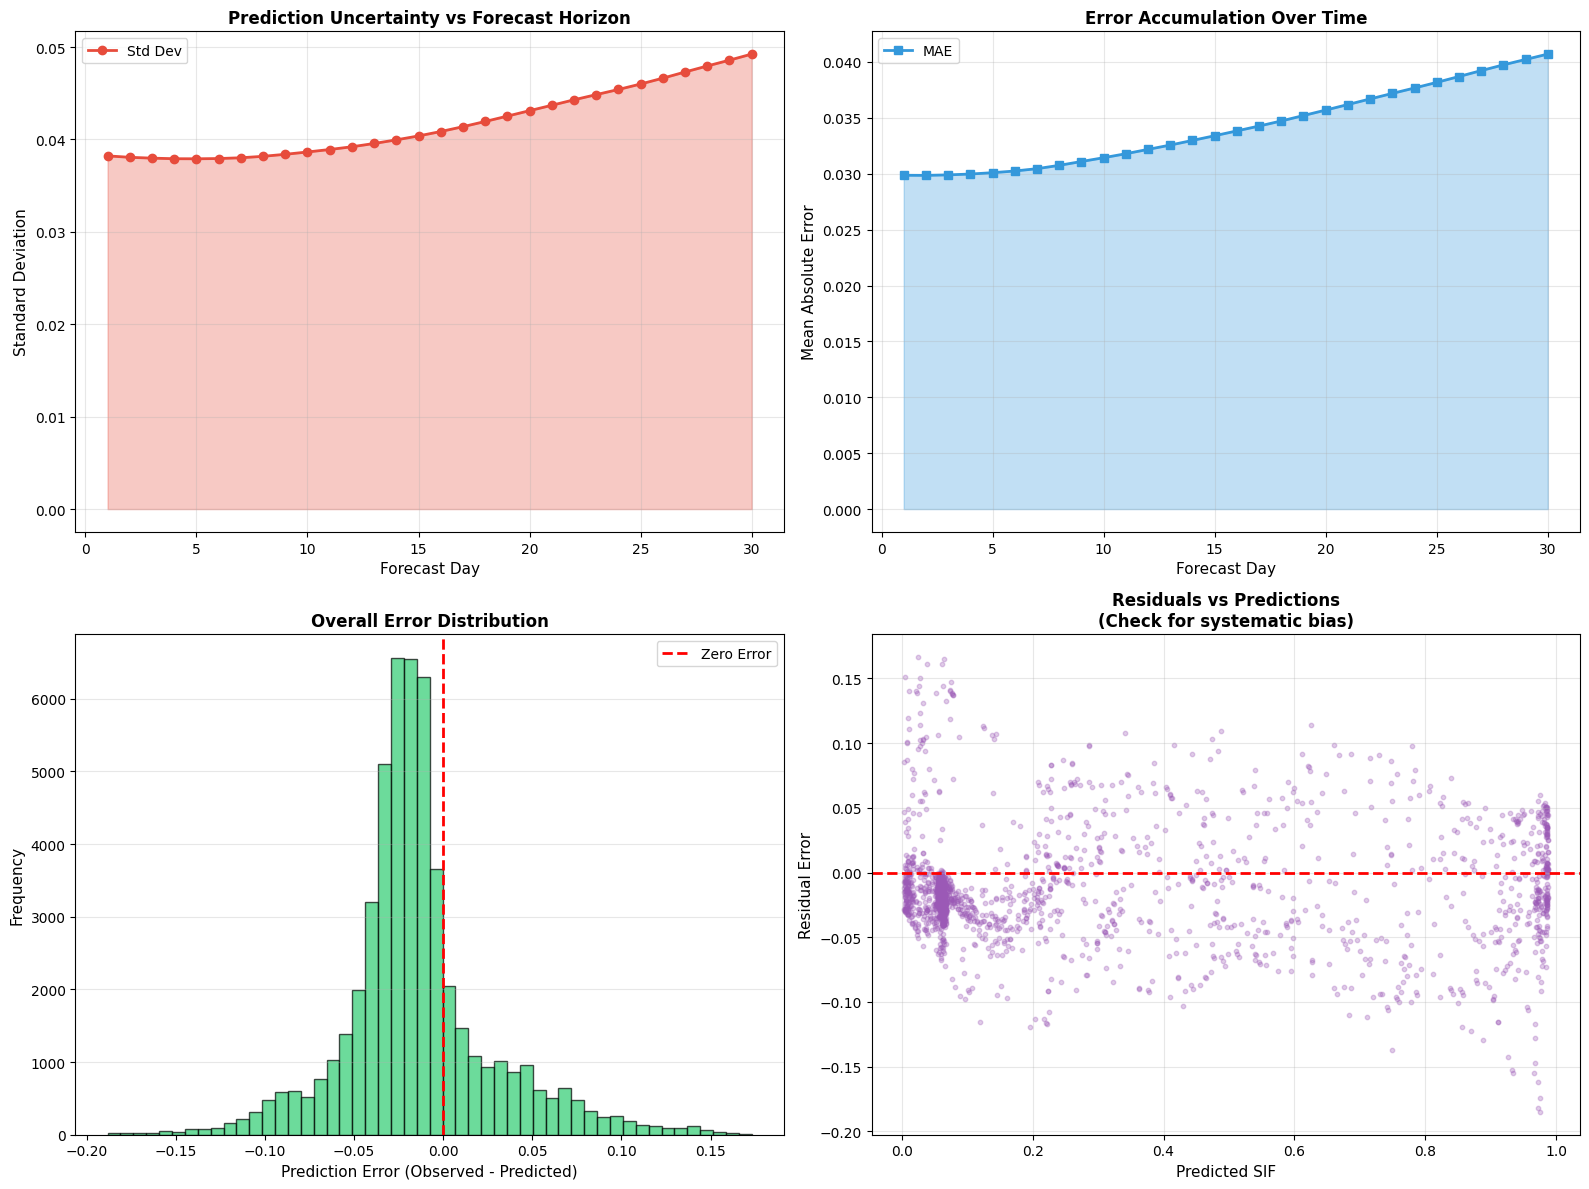


Uncertainty Summary:
  Mean uncertainty (std): 0.0418
  Uncertainty growth rate: 1.29x
  Residual skewness: -0.3555


In [31]:
# Analyze prediction uncertainty using residuals
residuals = y_true_orig - y_pred_orig

# Calculate uncertainty metrics
uncertainty_by_horizon = []
for day in range(pred_len):
    day_residuals = []
    for i in range(0, len(residuals), pred_len):
        if i + day < len(residuals):
            day_residuals.append(residuals[i + day])
    
    if len(day_residuals) > 0:
        day_residuals = np.array(day_residuals)
        uncertainty_by_horizon.append({
            'day': day + 1,
            'std': np.std(day_residuals),
            'mae': np.mean(np.abs(day_residuals)),
            'rmse': np.sqrt(np.mean(day_residuals**2))
        })

uncertainty_df = pd.DataFrame(uncertainty_by_horizon)

# Visualize uncertainty
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Uncertainty vs forecast horizon
ax1 = axes[0, 0]
ax1.plot(uncertainty_df['day'], uncertainty_df['std'], 'o-', linewidth=2, 
         markersize=6, color='#e74c3c', label='Std Dev')
ax1.fill_between(uncertainty_df['day'], 0, uncertainty_df['std'], alpha=0.3, color='#e74c3c')
ax1.set_xlabel('Forecast Day', fontsize=11)
ax1.set_ylabel('Standard Deviation', fontsize=11)
ax1.set_title('Prediction Uncertainty vs Forecast Horizon', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. MAE vs horizon
ax2 = axes[0, 1]
ax2.plot(uncertainty_df['day'], uncertainty_df['mae'], 's-', linewidth=2, 
         markersize=6, color='#3498db', label='MAE')
ax2.fill_between(uncertainty_df['day'], 0, uncertainty_df['mae'], alpha=0.3, color='#3498db')
ax2.set_xlabel('Forecast Day', fontsize=11)
ax2.set_ylabel('Mean Absolute Error', fontsize=11)
ax2.set_title('Error Accumulation Over Time', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Residual distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='#2ecc71')
ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax3.set_xlabel('Prediction Error (Observed - Predicted)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Overall Error Distribution', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend()

# 4. Error vs predicted value (heteroscedasticity check)
ax4 = axes[1, 1]
sample_indices = np.random.choice(len(y_pred_orig), min(2000, len(y_pred_orig)), replace=False)
ax4.scatter(y_pred_orig[sample_indices], residuals[sample_indices], 
           alpha=0.3, s=10, color='#9b59b6')
ax4.axhline(0, color='red', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted SIF', fontsize=11)
ax4.set_ylabel('Residual Error', fontsize=11)
ax4.set_title('Residuals vs Predictions\n(Check for systematic bias)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('uncertainty_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nUncertainty Summary:")
print(f"  Mean uncertainty (std): {uncertainty_df['std'].mean():.4f}")
print(f"  Uncertainty growth rate: {(uncertainty_df['std'].iloc[-1] / uncertainty_df['std'].iloc[0]):.2f}x")
print(f"  Residual skewness: {np.mean(residuals) / np.std(residuals):.4f}")

## 13. Model Performance Summary & Key Findings

In [42]:
print("\n Model Architecture")
print("-" * 80)
print(f"  Model Type: Temporal Fusion Transformer (TFT)")
print(f"  Input Features: {len(train_dataset.feature_cols)}")
print(f"  Feature Names: {', '.join(train_dataset.feature_cols)}")
print(f"  Hidden Size: 28")
print(f"  Attention Heads: 4")
print(f"  Sequence Length: {seq_len} days")
print(f"  Forecast Horizon: {pred_len} days")
print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")

print("\n  Metrics")
print("-" * 80)
print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"  MAE (Mean Absolute Error):      {mae:.4f}")
print(f"  R² Score:                       {r2:.4f}")
print(f"  Training Loss (final):          {train_losses[-1]:.4f}")
print(f"  Validation Loss (best):         {best_val_loss:.4f}")
print(f"  Training Epochs:                {len(train_losses)}")

print("\n Feature importance")
print("-" * 80)
for idx, row in importance_df.iterrows():
    bar_length = int(row['Importance'] * 50)
    bar = '█' * bar_length
    print(f"  {row['Feature']:15s} {bar:50s} {row['Importance']:.3f}")

print("\n Phenological Event Detection")
print("-" * 80)
total_samples = len(y_pred_orig) // pred_len
print(f"  Spring Green-up (SOS):  {len(greenup_samples):3d} samples ({len(greenup_samples)/total_samples*100:.1f}%)")
print(f"  Autumn Senescence (EOS): {len(senescence_samples):3d} samples ({len(senescence_samples)/total_samples*100:.1f}%)")
print(f"  Total Samples Analyzed:  {total_samples:3d}")

print("\n  Temporal Attention Patterns")
print("-" * 80)
# Check if attention variables were computed (depends on attention array format)
if 'lags' in locals() and 'attention_per_lag' in locals():
    print(f"  Peak attention at:      {lags[np.argmax(attention_per_lag)]:.0f} days lag")
    print(f"  Recent history weight:  {attention_per_lag[:30].sum()/attention_per_lag.sum()*100:.1f}%")
    print(f"  Mid-range weight:       {attention_per_lag[30:60].sum()/attention_per_lag.sum()*100:.1f}%")
    print(f"  Distant past weight:    {attention_per_lag[60:].sum()/attention_per_lag.sum()*100:.1f}%")
elif 'positions' in locals() and 'mean_attention' in locals():
    print(f"  Peak attention at:      {positions[np.argmax(mean_attention)]:.0f} position")
    print(f"  Average attention:      {mean_attention.mean():.4f}")
    if len(mean_attention) >= 30:
        print(f"  Recent history weight:  {mean_attention[:30].sum()/mean_attention.sum()*100:.1f}%")
        if len(mean_attention) >= 60:
            print(f"  Mid-range weight:       {mean_attention[30:60].sum()/mean_attention.sum()*100:.1f}%")
            print(f"  Distant past weight:    {mean_attention[60:].sum()/mean_attention.sum()*100:.1f}%")
else:
    print(f"  Attention analysis:     Limited (simplified attention format)")
    print(f"  See attention visualization cells for details")

print("\n Climate Driver Groups Aggregated)")
print("-" * 80)
overall_drivers = aggregate_drivers(feature_importance, train_dataset.feature_cols)
for driver, value in sorted(overall_drivers.items(), key=lambda x: x[1], reverse=True):
    bar_length = int((value / sum(overall_drivers.values())) * 50)
    bar = '█' * bar_length
    pct = (value / sum(overall_drivers.values())) * 100
    print(f"  {driver:15s} {bar:50s} {pct:.1f}%")


 Model Architecture
--------------------------------------------------------------------------------
  Model Type: Temporal Fusion Transformer (TFT)
  Input Features: 6
  Feature Names: tmin, tmax, radiation, precipitation, photoperiod, swvl1
  Hidden Size: 28
  Attention Heads: 4
  Sequence Length: 90 days
  Forecast Horizon: 30 days
  Total Parameters: 33,181

  Metrics
--------------------------------------------------------------------------------
  RMSE (Root Mean Squared Error): 0.0445
  MAE (Mean Absolute Error):      0.0342
  R² Score:                       0.9844
  Training Loss (final):          0.0327
  Validation Loss (best):         0.0144
  Training Epochs:                13

 Feature importance
--------------------------------------------------------------------------------
  photoperiod     ███████████████████                                0.387
  tmin            ████████                                           0.174
  tmax            ██████                         

## 14. Final Integrated Visualization
Combining all analyses into a comprehensive dashboard view.

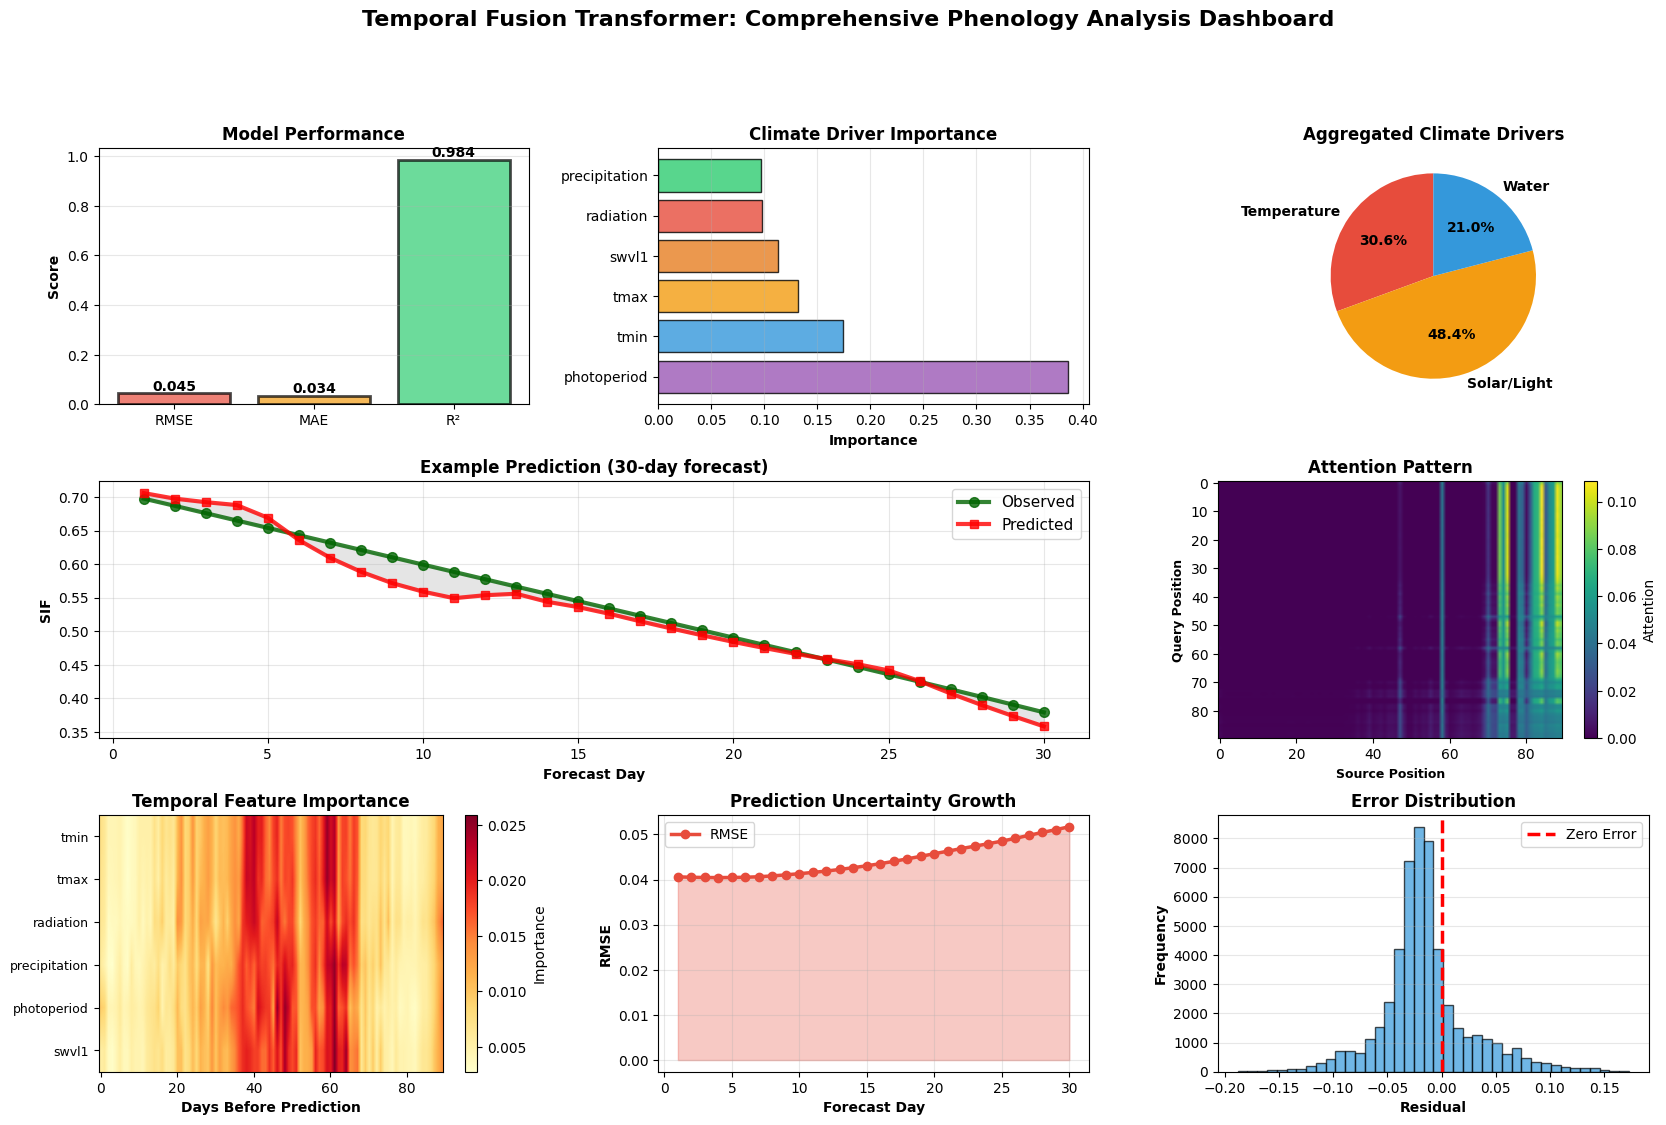

In [44]:
# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Model Performance (top left)
ax1 = fig.add_subplot(gs[0, 0])
metrics = ['RMSE', 'MAE', 'R²']
values = [rmse, mae, r2]
colors_metric = ['#e74c3c', '#f39c12', '#2ecc71']
bars = ax1.bar(metrics, values, color=colors_metric, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Model Performance', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Feature Importance (top middle)
ax2 = fig.add_subplot(gs[0, 1])
colors_feat = ['#2ecc71', '#e74c3c', '#e67e22', '#f39c12', '#3498db', '#9b59b6']
ax2.barh(importance_df['Feature'], importance_df['Importance'], 
         color=colors_feat[::-1], alpha=0.8, edgecolor='black', linewidth=1)
ax2.set_xlabel('Importance', fontweight='bold')
ax2.set_title('Climate Driver Importance', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Driver Groups (top right)
ax3 = fig.add_subplot(gs[0, 2])
driver_names = list(overall_drivers.keys())
driver_values = list(overall_drivers.values())
colors_drivers = ['#e74c3c', '#f39c12', '#3498db']
wedges, texts, autotexts = ax3.pie(driver_values, labels=driver_names, autopct='%1.1f%%',
                                     colors=colors_drivers, startangle=90, 
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})
ax3.set_title('Aggregated Climate Drivers', fontsize=12, fontweight='bold')

# 4. Sample Prediction (middle left)
ax4 = fig.add_subplot(gs[1, :2])
sample_idx = 5
start_idx = sample_idx * pred_len
end_idx = start_idx + pred_len
if end_idx <= len(y_pred_orig):
    pred_series = y_pred_orig[start_idx:end_idx].flatten()
    true_series = y_true_orig[start_idx:end_idx].flatten()
    days = np.arange(1, len(pred_series) + 1)
    
    ax4.plot(days, true_series, 'o-', color='darkgreen', label='Observed', 
            linewidth=3, markersize=7, alpha=0.8)
    ax4.plot(days, pred_series, 's-', color='red', label='Predicted', 
            linewidth=3, markersize=6, alpha=0.8)
    ax4.fill_between(days, true_series, pred_series, alpha=0.2, color='gray')
    ax4.set_xlabel('Forecast Day', fontweight='bold')
    ax4.set_ylabel('SIF', fontweight='bold')
    ax4.set_title('Example Prediction (30-day forecast)', fontsize=12, fontweight='bold')
    ax4.legend(loc='best', fontsize=11, frameon=True)
    ax4.grid(True, alpha=0.3)

# 5. Attention Pattern (middle right)
ax5 = fig.add_subplot(gs[1, 2])
sample_attn = attention_array[0]

# Handle different attention formats
if sample_attn.ndim == 3 and sample_attn.shape[1] == sample_attn.shape[2]:
    # Full attention matrix: (num_heads, seq_len, seq_len)
    mean_attn = sample_attn.mean(axis=0)  # Average over heads -> (seq_len, seq_len)
    im = ax5.imshow(mean_attn, cmap='viridis', aspect='auto', interpolation='bilinear')
    ax5.set_xlabel('Source Position', fontweight='bold', fontsize=9)
    ax5.set_ylabel('Query Position', fontweight='bold', fontsize=9)
    ax5.set_title('Attention Pattern\n(Avg over heads)', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax5, label='Attention')
elif sample_attn.ndim == 2 and sample_attn.shape[1] == sample_attn.shape[0]:
    # 2D attention matrix: (seq_len, seq_len) already averaged
    im = ax5.imshow(sample_attn, cmap='viridis', aspect='auto', interpolation='bilinear')
    ax5.set_xlabel('Source Position', fontweight='bold', fontsize=9)
    ax5.set_ylabel('Query Position', fontweight='bold', fontsize=9)
    ax5.set_title('Attention Pattern', fontsize=12, fontweight='bold')
    plt.colorbar(im, ax=ax5, label='Attention')
else:
    # 1D or other format - show as line plot
    mean_attn = sample_attn.mean(axis=0) if sample_attn.ndim > 1 else sample_attn
    positions = np.arange(len(mean_attn))
    ax5.plot(positions, mean_attn, linewidth=2, color='darkblue', marker='o', markersize=4)
    ax5.fill_between(positions, mean_attn, alpha=0.3, color='darkblue')
    ax5.set_xlabel('Sequence Position', fontweight='bold', fontsize=9)
    ax5.set_ylabel('Attention Weight', fontweight='bold', fontsize=9)
    ax5.set_title('Attention Pattern\n(Avg per position)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)

# 6. Temporal Importance (bottom left)
ax6 = fig.add_subplot(gs[2, 0])
im6 = ax6.imshow(temporal_importance.T, cmap='YlOrRd', aspect='auto', interpolation='bilinear')
ax6.set_yticks(range(len(train_dataset.feature_cols)))
ax6.set_yticklabels(train_dataset.feature_cols, fontsize=9)
ax6.set_xlabel('Days Before Prediction', fontweight='bold')
ax6.set_title('Temporal Feature Importance', fontsize=12, fontweight='bold')
plt.colorbar(im6, ax=ax6, label='Importance')

# 7. Uncertainty (bottom middle)
ax7 = fig.add_subplot(gs[2, 1])
ax7.plot(uncertainty_df['day'], uncertainty_df['rmse'], 'o-', linewidth=2.5, 
         markersize=6, color='#e74c3c', label='RMSE')
ax7.fill_between(uncertainty_df['day'], 0, uncertainty_df['rmse'], alpha=0.3, color='#e74c3c')
ax7.set_xlabel('Forecast Day', fontweight='bold')
ax7.set_ylabel('RMSE', fontweight='bold')
ax7.set_title('Prediction Uncertainty Growth', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3)
ax7.legend()

# 8. Error Distribution (bottom right)
ax8 = fig.add_subplot(gs[2, 2])
ax8.hist(residuals, bins=40, edgecolor='black', alpha=0.7, color='#3498db')
ax8.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Zero Error')
ax8.set_xlabel('Residual', fontweight='bold')
ax8.set_ylabel('Frequency', fontweight='bold')
ax8.set_title('Error Distribution', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# Add overall title
fig.suptitle('Temporal Fusion Transformer: Comprehensive Phenology Analysis Dashboard', 
             fontsize=16, fontweight='bold', y=0.995)

plt.savefig('comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

